# Gradient Boosting and Stochastic Models for Predicting FOMC Meetings Impact

<a href="https://www.kaggle.com/code/addarm/bond-valuations" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/adamd1985/quant_research/blob/main/bond_valuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Bonds 2024.07.24](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/bondbanner.png)

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

In this study, we use stochastic financial modeling and machine learning to estimated the impact of Federal Open Market Committee (FOMC) announcements on the market. Specifically, we implement the Heston Stochastic Volatility Model and Ornstein-Uhlenbeck process to simulate market movements and analyze their efficacy in forecasting market reactions. 

Additionally, we utilize machine learning techniques, including Gradient Boosting Classifiers and Bayesian Optimization, to enhance prediction accuracy.

## Notebook Setup

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

import warnings
warnings.filterwarnings("ignore")

INSTALL_DEPS = False
if INSTALL_DEPS:
    # If Kaggle or Colab, you have to manage these. If local, install all
    %pip install numpy==1.23.4
    %pip install pandas==2.2.0

    IN_KAGGLE = IN_COLAB = False
try:
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/fomc_dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    DATA_PATH = "/kaggle/input/fomc_dataset"
    MODEL_PATH = "."
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    DATA_PATH = "./data/macro"
    MODEL_PATH = "./models/fomc/"
    print("running localhost!")

running localhost!


# Heston Stochastic Volatility Model

The Heston model is a popular stochastic volatility model used to describe the evolution of an underlying asset with stochastic volatility. The model assumes that the underlying asset price $S_t$ and its variance $V_t$ follow the stochastic differential equations:

$$
\begin{aligned}
    dS_t &= \mu S_t dt + \sqrt{V_t} S_t dW_{1,t}, \\
    dV_t &= \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_{2,t}, \\
    dW_{1,t} dW_{2,t} &= \rho dt,
\end{aligned}
$$

where:
- $S_t$ is the asset price at time $t$,
- $V_t$ is the variance at time $t$,
- $\mu$ is the drift rate of the asset,
- $\kappa$ is the rate of mean reversion of variance,
- $\gamma$ is the long-term variance,
- $\sigma$ is the volatility of the variance process,
- $W_{1,t}$ and $W_{2,t}$ are Wiener processes with correlation $\rho$.
 
This continuous-time Equations has 2 theoretical SDEs that describe how the price and variance evolve continuously over time, though it needs to be descritized to be applied in a numerical solution

## Discretized Heston Model

Using the Euler-Maruyama method to discretize the model:

$$
X_t = X_{t-1} + \mu X_{t-1} \, dt + \sqrt{\zeta_{t-1}} X_{t-1} \sqrt{dt} Z_{t1}
$$

Where:
- $X_t$ is the stock price at time $t$.
- $\mu$ is the drift term, representing the expected return of the stock.
- $dt$ is the size of the time step.
- $\zeta_{t-1}$ is the variance at time $t-1$.
- $Z_{t1}$ is a standard normal random variable representing the random shock to the stock price.

Same for the variance equation:

$$
\zeta_t = \zeta_{t-1} + \kappa (\gamma - \zeta_{t-1}) \, dt + \sigma_\zeta \sqrt{\zeta_{t-1}} \sqrt{dt} Z_{t2}
$$

Where:
- $\zeta_t$ is the variance at time $t$.
- $\kappa$ is the rate of mean reversion, dictating how quickly the variance reverts to the long-run average $\gamma$.
- $\gamma$ is the long-run average variance.
- $\sigma_\zeta$ is the volatility of the variance process.
- $Z_{t2}$ is a standard normal random variable representing the random shock to the variance.

in both equations $dt$ is the timestep, calculated as:

$$
dt = \frac{T}{N}
$$

Where:
- $T$ is the annualized Time Horizon, in years.
- $N$ is the number of discrete steps (in days) the time horizon is divided.

The random variables $Z_{t1}$ and $Z_{t2}$ are correlated with correlation coefficient $\rho$. We can generate correlated random variables as follows:

$$
Z_{t1} = G_{t1}
$$

$$
Z_{t2} = \rho G_{t1} + \sqrt{1 - \rho^2} G_{t2}
$$

Where:
- $\rho$ is the correlation between the stock price and variance processes.
- $Z_{t2}$ is constructed to have the desired correlation with $Z_{t1}$.
- $G_{t2}$ ensures that $Z_{t2}$ is also a standard normal random variable.

### Jumps with  Poisson Process

We are simulating market impact, therefore there will be a shock in the Heston process which we should simulate using Poisson. The Poisson process is used to model the occurrence of random events over time:

1. The probability of exactly one event occurring in a small interval of length $dt$ is $\lambda dt + o(dt)$.
2. The probability of more than one event occurring in a small interval of length $dt$ is $o(dt)$.
3. The probability of no events occurring in a small interval of length $dt$ is $1 - \lambda dt + o(dt)$.

The number of events $N(t)$ occurring up to time $t$ follows the Poisson distribution:
$$
P(N(t) = k) = \frac{(\lambda t)^k e^{-\lambda t}}{k!}, \quad k = 0, 1, 2, \ldots
$$
where $k$ represents the number of events (or jumps) that occur up to time $t$, and $\lambda$ is the frequency of jumps

In our Heston model, we include 2 new paramaters:

1. **Jump Occurrence**: The Poisson process determines if a jump occurs during each time step.
2. **Jump Magnitude**: When a jump occurs, the magnitude is typically modeled using a normal distribution.

In [2]:
def heston_model(X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N, pos_jump_proba=0.05, neg_jump_proba=0.05, jump_mean=0.005, jump_std=0.015):
    dt = T / N
    X = np.zeros(N+1)
    v = np.zeros(N+1)
    X[0] = X0
    v[0] = v0
    pos_lambda = pos_jump_proba / dt
    neg_lambda = neg_jump_proba / dt
    for t in range(1, N+1):
        Gt1 = np.random.normal(0, 1)
        Gt2 = np.random.normal(0, 1)
        Zt1 = Gt1
        Zt2 = rho * Gt1 + np.sqrt(1 - rho**2) * Gt2

        v[t] = v[t-1] + kappa * (gamma - v[t-1]) * dt + sigma_variance * np.sqrt(v[t-1]) * np.sqrt(dt) * Zt2
        v[t] = max(v[t], 0)  # Ensure variance stays non-negative
        X[t] = X[t-1] * np.exp((mu - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * Zt1)

        # Convert into rates per unit time interval
        pos_jump_occurs = np.random.poisson(pos_lambda) > 0
        neg_jump_occurs = np.random.poisson(neg_lambda) > 0

        if pos_jump_occurs:
            pos_jump_size = np.random.normal(jump_mean, jump_std)
            X[t] *= np.exp(pos_jump_size)
        elif neg_jump_occurs:
            neg_jump_size = np.random.normal(jump_mean, jump_std)
            X[t] *= np.exp(-neg_jump_size)

    # Don't return X0 and V0
    return X[1:], v[1:]

Let's do some tests to see that our Heston gives sensible results:

In [3]:
X0 = 100  # Initial stock price
variance0 = 0.04  # Initial variance (square of initial volatility)
mu = 0.05  # Drift of stock price
kappa = 1.0  # Speed of mean reversion of variance
theta = 0.04  # Long run average variance
sigma_variance = 0.2  # Volatility of variance
rho = -0.7  # Correlation between the two Wiener processes
T = 5 / 252  # Time horizon (1 week, represented as 5/252 years)
N = 5  # Number of time steps (5 trading days)

# Simulate without shocks
X, variance = heston_model(
    X0, variance0, mu, kappa, theta, sigma_variance, rho, T, N
)

X, variance

(array([ 99.61503436, 102.72631408, 103.41345982, 104.55730754,
        104.49917466]),
 array([0.03565255, 0.03379836, 0.03094816, 0.0295553 , 0.02463217]))

# FOMC and Macro Datasets

Note the probabilities for jumps in the Heston parameters. We need to supply those through historic data. Our aim is to use machine learning (ML) to supply such probabilities. 

Through various data repositories, we built a dataset and did feature engineering to give an edge to our models:

In [4]:
macro_df = pd.read_csv(f"{DATA_PATH}/FOMC_dataset.csv")

macro_df['Date'] = pd.to_datetime(macro_df['Date'])
macro_df['Year'] = macro_df['Date'].dt.year
macro_df['Month'] = macro_df['Date'].dt.month
macro_df['Quarter'] = macro_df['Date'].dt.quarter

macro_df['Month_Sin'] = np.sin(2 * np.pi * macro_df['Month'] / 12)
macro_df['Month_Cos'] = np.cos(2 * np.pi * macro_df['Month'] / 12)

macro_df['YoY Industry Production'] = macro_df['Industry Production'].pct_change(periods=12).bfill()
macro_df['YoY PCE'] = macro_df['PCE'].pct_change(periods=12).bfill()
macro_df['YoY Retail Sales'] = macro_df['Retail Sales'].pct_change(periods=12).bfill()
macro_df['YoY Unemployment'] = macro_df['Unemployment'].pct_change(periods=12).bfill()
macro_df['YoY Wage Increase'] = macro_df['Wage Increase'].pct_change(periods=12).bfill()
macro_df['YoY Home Sales'] = macro_df['Home Sales'].pct_change(periods=12).bfill()
macro_df['YoY Retail Trade'] = macro_df['Retail Trade'].pct_change(periods=12).bfill()
macro_df['YoY Real GDP'] = macro_df['Real GDP'].pct_change(periods=12).bfill()

macro_df['MoM Industry Production'] = macro_df['Industry Production'].pct_change(periods=1).bfill()
macro_df['MoM PCE'] = macro_df['PCE'].pct_change(periods=1).bfill()
macro_df['MoM Retail Sales'] = macro_df['Retail Sales'].pct_change(periods=1).bfill()
macro_df['MoM Unemployment'] = macro_df['Unemployment'].pct_change(periods=1).bfill()
macro_df['MoM Wage Increase'] = macro_df['Wage Increase'].pct_change(periods=1).bfill()
macro_df['MoM Home Sales'] = macro_df['Home Sales'].pct_change(periods=1).bfill()
macro_df['MoM Retail Trade'] = macro_df['Retail Trade'].pct_change(periods=1).bfill()
macro_df['MoM Real GDP'] = macro_df['Real GDP'].pct_change(periods=1).bfill()

macro_df['CPI_Unemployment'] = macro_df['CPI'] * macro_df['Unemployment']
macro_df['CPI_Industry Production'] = macro_df['CPI'] * macro_df['Industry Production']

lags = [1, 3, 6, 12]
for lag in lags:
    macro_df[f'Industry Production Lag_{lag}'] = macro_df['Industry Production'].shift(lag).bfill()
    macro_df[f'PCE Lag_{lag}'] = macro_df['PCE'].shift(lag).bfill()
    macro_df[f'Retail Sales Lag_{lag}'] = macro_df['Retail Sales'].shift(lag).bfill()
    macro_df[f'Unemployment Lag_{lag}'] = macro_df['Unemployment'].shift(lag).bfill()
    macro_df[f'Wage Increase Lag_{lag}'] = macro_df['Wage Increase'].shift(lag).bfill()
    macro_df[f'Home Sales Lag_{lag}'] = macro_df['Home Sales'].shift(lag).bfill()
    macro_df[f'Retail Trade Lag_{lag}'] = macro_df['Retail Trade'].shift(lag).bfill()
    macro_df[f'Real GDP Lag_{lag}'] = macro_df['Real GDP'].shift(lag).bfill()

macro_df.sort_values(by="Date", ascending=True)
print(f"Shape: {macro_df.shape}")
macro_df.tail(5)

Shape: (2492, 105)


,Unnamed: 0,Date,CPI,Industry Production,PCE,Retail Sales,Unemployment,Wage Increase,Fed Rate,Home Sales,...,Retail Trade Lag_6,Real GDP Lag_6,Industry Production Lag_12,PCE Lag_12,Retail Sales Lag_12,Unemployment Lag_12,Wage Increase Lag_12,Home Sales Lag_12,Retail Trade Lag_12,Real GDP Lag_12
2487,2487,2024-03-01,312.332000,102.406,122.782000,225391.0,3.8,368.0,5.33,683.0,...,608307.0,22679.255,102.381,120.221,226521.0,3.6,366.0,666.0,597826.0,22490.692
2488,2488,2024-04-01,313.548000,102.433,123.109000,224350.0,3.9,368.0,5.33,730.0,...,606596.0,22679.255,102.381,120.221,226521.0,3.6,366.0,666.0,597826.0,22490.692
2489,2489,2024-05-01,314.069000,103.328,123.146000,224913.0,4.0,368.0,5.33,621.0,...,606035.0,22758.752,103.072,120.373,226640.0,3.5,366.0,700.0,599037.0,22490.692
2490,2490,2024-06-01,314.175000,103.994,123.243000,224988.0,4.1,368.0,5.33,617.0,...,608730.0,22758.752,103.072,120.373,226640.0,3.5,366.0,700.0,599037.0,22490.692
2491,2491,2024-07-01,314.489175,103.994,123.489486,224988.0,4.1,368.0,5.33,612.0,...,601921.0,22758.752,103.072,120.373,226640.0,3.5,366.0,700.0,599037.0,22490.692


In [5]:
FEATURES = [
    "CPI", "Industry Production", "PCE", "Retail Sales", "Unemployment",
    "Wage Increase", "Prior Fed Rate", "Home Sales", "Retail Trade",
    "Real GDP", "Month", "Month_Sin", "Month_Cos", "Prior CPI", "Inflation",
    "YoY Industry Production", "YoY PCE", "YoY Retail Sales", "YoY Unemployment",
    "YoY Wage Increase", "YoY Home Sales", "YoY Retail Trade", "YoY Real GDP",
    "MoM Industry Production", "MoM PCE", "MoM Retail Sales", "MoM Unemployment",
    "MoM Wage Increase", "MoM Home Sales", "MoM Retail Trade", "MoM Real GDP",
    "CPI_Unemployment", "CPI_Industry Production",
    "Industry Production_Quarterly_Avg", "PCE_Quarterly_Avg", "Retail Sales_Quarterly_Avg",
    "Unemployment_Quarterly_Avg", "Wage Increase_Quarterly_Avg", "Home Sales_Quarterly_Avg",
    "Retail Trade_Quarterly_Avg", "Real GDP_Quarterly_Avg"
]

# Machine Learning for Probabilities

We want to predict 2 things:
- Class 0: Status Quo, this means the Fed keeps the rates or decreases them (what the market is pricing in).
- Class 1: Rates Increase, inflation is persistant and the Fed will increase again the rates, which would lead to some market tormoil.

From our macro data we will engineer this label by comparing the current Fed Rate with the next time step's Fed Rate:

In [6]:
macro_df['Fed Rate Increase'] = ((macro_df['Fed Rate'] - macro_df['Prior Fed Rate']) > 0).astype(int) # our label

counts = macro_df['Fed Rate Increase'].value_counts()
counts

Fed Rate Increase
0    1270
1    1222
Name: count, dtype: int64

Note there is a slight imbalance between meetings that led to increases and keeping the status quo, for this we will use Synthetic Minority Oversampling Technique (SMOTE) to balance them out again.

The dataset has 2492 rows and 105, emsembles or tree classifiers perform well on such small datasets.
We will run some trails with a subset of such models, using out of the box parameters and stratified cross validation.

The models are:
- Naive Bayes
- State Vector Machines (SVM)
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting

Below is the python code to scale the data, cross validate and test these:

In [7]:
import json
import os
import pandas as pd
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = macro_df[FEATURES]
y = macro_df['Fed Rate Increase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

models = {
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

best_models = {}
metrics = []

if os.path.exists(f"{MODEL_PATH}/fomc_all_metrics.json"):
    metrics_df = pd.read_json(f"{MODEL_PATH}/fomc_all_metrics.json")
else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in tqdm(models.items(), desc="Training Models..."):
        model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
        best_models[model_name] = model
        y_pred = model.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        X_scaled = scaler.fit_transform(X)  # Scale the entire dataset for cross-validation
        cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='precision_weighted')
        cv_mean = cv_scores.mean()

        metrics.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "CV Score": cv_mean
        })

    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_json(f"{MODEL_PATH}/fomc_all_metrics.json")

metrics_df = metrics_df.sort_values(by=["CV Score", "Precision"], ascending=False)
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,CV Score
3,Decision Tree,0.576203,0.577456,0.576203,0.575962,0.576989
5,Gradient Boosting,0.538770,0.541155,0.538770,0.537238,0.575136
4,Random Forest,0.553476,0.553535,0.553476,0.553501,0.573873
0,Naive Bayes,0.513369,0.538695,0.513369,0.454407,0.546882
1,SVM,0.494652,0.495779,0.494652,0.494067,0.543152
2,Logistic Regression,0.526738,0.528089,0.526738,0.526190,0.534921


The top performing was the GBC, no surprise there, these algos are excellent for tabular data.

## Fine-Tune the Gradient Boosting Classifier

Now we will sampling the models hyperparameters using the bayes optimization library to find the right parameters.

The library will create gaussian distribution to maximize the function we will provide it, and using exploration and exploitation will find the upper limits of the parameters. The problem of this library is that it only works with continuous parameters, and discrete or categorical parameters will need the more traditional gridsearch.

It's also fast!

In [8]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve

def max_function(n_estimators, max_depth, learning_rate, min_samples_split, min_samples_leaf, sample_weights=None):
    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision', params={'sample_weight': sample_weights})
    return scores.mean()

param_bounds = {
    'n_estimators': (20, 1000),
    'max_depth': (2, 10),
    'learning_rate': (0.001, 0.5),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 20),
}

if os.path.exists(f"{MODEL_PATH}/fomc_model.joblib"):
    best_model = joblib.load(f"{MODEL_PATH}/fomc_model.joblib")
    scaler = joblib.load(f"{MODEL_PATH}/fomc_model_scaler.joblib")
    with open(f"{MODEL_PATH}/fomc_model_params.json", 'r') as file:
        best_params = json.load(file)
    metrics_df = pd.read_json(f"{MODEL_PATH}/fomc_model_metrics.json")

    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    scaler = StandardScaler()
    X_train_scaled  = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    optimizer = BayesianOptimization(
        f=max_function,
        pbounds=param_bounds,
        random_state=42,
        verbose=2
    )
    if os.path.exists(f"{MODEL_PATH}/cv_logs.log"):
        load_logs(optimizer, logs=[f"{MODEL_PATH}/cv_logs.log"])
    optimizer.maximize(
        init_points=10,
        n_iter=20,
    )
    logger = JSONLogger(path=f"{MODEL_PATH}/cv_logs.log")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

    best_model = GradientBoostingClassifier(
        **best_params,
        random_state=42
    )
    best_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=cv, scoring='precision', params={'sample_weight': sample_weights})
    cv_mean = cv_scores.mean()

    metrics = {
        "Model": "Gradient Boosting Classifier",
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1,
        "AUC": auc,
        "CV Score": cv_mean
    }

    metrics_df = pd.DataFrame([metrics])
    with open(f"{MODEL_PATH}/fomc_model_params.json", 'w') as file:
        json.dump(best_params, file)
    metrics_df.to_json(f"{MODEL_PATH}/fomc_model_metrics.json")
    joblib.dump(best_model, f"{MODEL_PATH}/fomc_model.joblib")
    joblib.dump(scaler, f"{MODEL_PATH}/fomc_model_scaler.joblib")
print("Best model parameters:", best_params)
metrics_df

Best model parameters: {'learning_rate': 0.3095658451441815, 'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 16, 'n_estimators': 200}


,Model,Accuracy,Recall,Precision,F1 Score,AUC,CV Score
0,Gradient Boosting Classifier,0.557114,0.557377,0.546185,0.551724,0.575796,0.614214


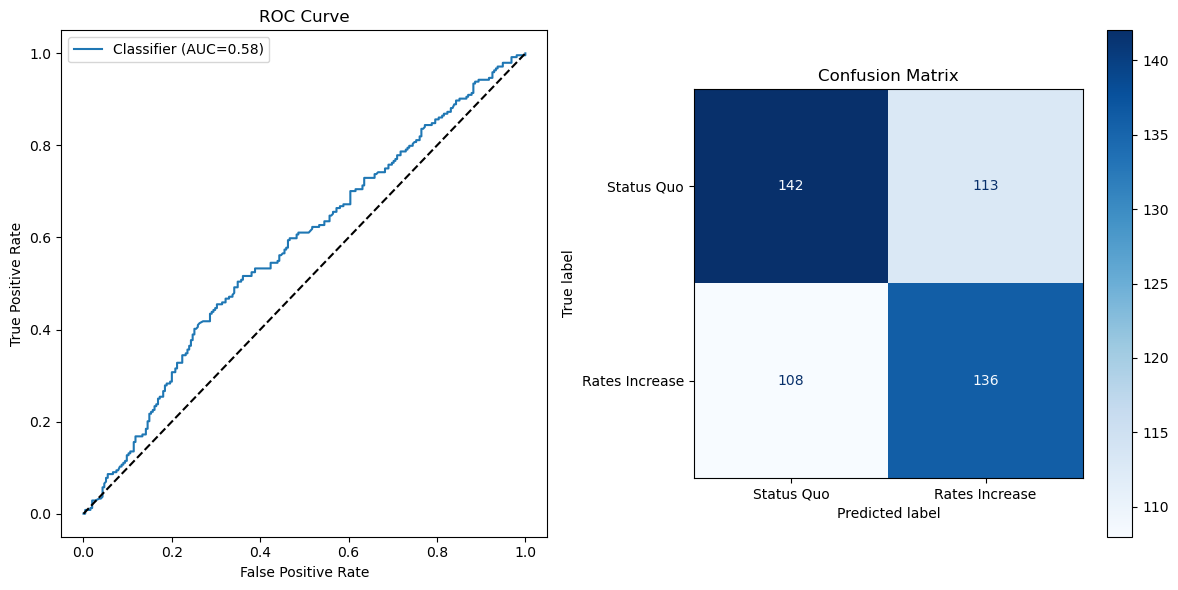

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

def classification_plots(X_test, y_test, best_model, scaler, metrics_df):
    X_test_scaled = scaler.transform(X_test)
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = metrics_df['AUC'].iloc[-1]
    ax[0].plot(fpr, tpr, label=f"Classifier (AUC={auc:.2f})")
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curve')
    ax[0].legend(loc='best')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Status Quo', 'Rates Increase'])
    disp.plot(cmap='Blues', ax=ax[1])
    ax[1].set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

classification_plots(X_test, y_test, best_model, scaler, metrics_df)

The confusion matrix and ROC curves show a worrisome story, there are quite a number of false positives and negatives. Our GBC has a 60% precisioon rate though, this is better than random chance but far from perfect.

FOMC outcomes involve large ammount of data taken from many economic domains, so we are doing a best effort to estimate the outcome here.

Below we test the rubustness of the classifier by purturbing it with gaussian noise:

In [10]:
def perturb_gaussiannoise(X, noise_level=0.01):
    sigma = noise_level * np.std(X)
    noise = np.random.normal(0, sigma, X.shape)
    return X + noise

def test_robustness():
    X_train_scaled  = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_pert = perturb_gaussiannoise(X_train_scaled)
    X_test_pert = perturb_gaussiannoise(X_test_scaled)
    y_pred = best_model.predict(X_test_pert)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_train_pert, y_train, cv=cv, scoring='precision', params={'sample_weight': sample_weights})
    cv_mean = cv_scores.mean()
    perturb_metrics = {
        "Model": "Gradient Boosting Classifier (Perturbed)",
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1,
        "AUC": auc,
        "CV Score": cv_mean
    }

    new_metrics_df = pd.concat([metrics_df, pd.DataFrame([perturb_metrics])], ignore_index=True)
    return new_metrics_df

test_robustness()

,Model,Accuracy,Recall,Precision,F1 Score,AUC,CV Score
0,Gradient Boosting Classifier,0.557114,0.557377,0.546185,0.551724,0.575796,0.614214
1,Gradient Boosting Classifier (Perturbed),0.539078,0.491803,0.530973,0.510638,0.539272,0.558799


The model is robust, with minor gaussian noise it had small degredation in the classification scores, but still better than random chance.

Finally, we have a look at what the model deems important: PCE, inflation and unemployment are economically sound, as this is what the Fed has been focusing during these times of inflation. Retail and GDP not so much, which might be relevant for the next FOMC (at the time of writing 31st July 2024) as there was a GDP surprise of 2.8 when the expected was 2.1.

In [11]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_ranking = pd.DataFrame({
    'Feature': [FEATURES[i] for i in indices],
    'Importance': importances[indices]
})


sorted_feature_ranking = feature_ranking.sort_values(by="Importance", ascending=True)
top_features = sorted_feature_ranking.tail(5)
bottom_features = sorted_feature_ranking.head(5)

combined_df = pd.concat([bottom_features.reset_index(drop=True), top_features.reset_index(drop=True)], axis=1)
combined_df

,Feature,Importance,Feature,Importance
0,Retail Trade_Quarterly_Avg,0.000912,MoM PCE,0.033979
1,Retail Sales_Quarterly_Avg,0.001713,Inflation,0.039748
2,MoM Real GDP,0.001843,YoY Home Sales,0.040015
3,Real GDP_Quarterly_Avg,0.004486,CPI_Unemployment,0.054667
4,PCE_Quarterly_Avg,0.005121,Prior Fed Rate,0.330581


# Market Data

Now we get the market data, we will use the ETF SPY as proxy for the market, we won't use use the SnP index itself due to its large numbers which might skew the simulations.

In [12]:
import yfinance as yf

SPY_TICKER = "SPY" # SnP 500 Index

macro_df['FOMC Meeting'] = pd.to_datetime(macro_df['FOMC Meeting'], errors='coerce')
macro_df['FOMC Meeting'] = macro_df['FOMC Meeting'].dt.tz_localize(None)
filtered_meetings = macro_df[(macro_df['FOMC Meeting'] >= '2023-06-01') & (macro_df['FOMC Meeting'] <= '2024-08-01')]
filtered_meetings = filtered_meetings.dropna().drop_duplicates()

market_df = yf.download(SPY_TICKER, start='2020-01-01', end='2024-07-01', interval='1d')
market_df.index = market_df.index.tz_localize(None)
market_df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,303.135620,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,300.840149,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,301.987854,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,301.138855,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,302.743713,68296000


Going back to the Heston, most of its parameters can sensibly be estimated from our data. With the exception of Kappa, Kappa is the speed of mean reversion and that needs its own model to estimate. For this we will use the Ornstein-Uhlenbeck.

## Ornstein-Uhlenbeck (OU) Process

An Ornstein–Uhlenbeck process is defined by this SDE:

$$
dx_t = \gamma(\mu - x_t)dt + \sigma dW_t
$$
Where:
- $\gamma$ is the rate of mean reversion.
- $\mu$ is the long-term mean.
- $\sigma$ is the volatility.
- $dW_t$ is the increment of a Wiener process (Brownian motion).

With the help of the Itô lemma, we can find a continuous-time solution:

$$
x_t = x_0 e^{-\gamma t} + \mu(1 - e^{-\gamma t}) + \sigma \int_0^t e^{-\gamma(t-s)} dW_s
$$

Its first two moments of its equilibrium distribution become:

$$
E[x_t] = x_0 e^{-\gamma t} + \mu(1 - e^{-\gamma t}) \rightarrow \mu
$$
As $t \rightarrow \infty$, $E[x_t]$ approaches $\mu$, showing that the process reverts to the mean $\mu$ over time.

$$
Var[x_t] = \frac{\sigma^2}{2\gamma} (1 - e^{-2\gamma t}) \rightarrow \frac{\sigma^2}{2\gamma}
$$
As $t \rightarrow \infty, Var[x_t]$ approaches $\frac{\sigma^2}{2\gamma}$, indicating the long-term variance of the process.

Its half-life is defined as the (expected) time to return half way to its mean, or:

$$
E[x_{\kappa}] - \mu = \frac{x_0 - \mu}{2}
$$

Substituting the expectation at time $\kappa$ with the discretized form, its left-hand-side becomes:
$$
E[x_{\kappa}] - \mu = x_0 e^{-\gamma \kappa} + \mu(1 - e^{-\gamma \kappa}) - \mu 
= e^{-\gamma \kappa} (x_0 - \mu)
$$

Solving it with right-hand-side gives the half-life $\kappa$:

$$
e^{-\gamma \kappa} (x_0 - \mu) = \frac{x_0 - \mu}{2} \implies \kappa = \frac{−\log(2)}{\gamma}
$$

A large $\gamma$ is a short half life, having strong mean-reversion effect.


We still have to find $\gamma$. Using the Euler-Maruyama method, for a small discrete time step $\Delta t$:

$$
x_{t + \Delta t} - x_t \approx \gamma(\mu - x_t)\Delta t + \sigma \sqrt{\Delta t} \epsilon_t
$$

Rewriting for $x_{t+1}$:

$$
x_{t+1} = x_t + \gamma(\mu - x_t)\Delta t + \sigma \sqrt{\Delta t} \epsilon_t 
$$

Simplifying the expression:

$$
x_{t+1} = \gamma \mu \Delta t + (1 - \gamma \Delta t)x_t + \sigma \sqrt{\Delta t} \epsilon_t 
$$

We can rewrite this equation in a linear regression form for 1 time step $\Delta t=1$:

$$
x_{t+1} = \alpha + \beta x_t + \epsilon_t
$$

where:

$$
\alpha = \gamma \mu 
$$

$$
\beta = 1 - \gamma  
$$

Using ordinary least squares (OLS) or any linear regression model, we can estimate the parameters $\alpha$ and $\beta$ from the data. We ignore the error term $\epsilon$. Once we have these estimates, we can solve for $\gamma$ as follows:

1. Estimate $\alpha$ and $\beta$:

$$
x_{t+1} = \alpha + \beta x_t 
$$

2. Solve for $\gamma$ from the estimated slope $\beta$:

$$
\gamma = 1 - \beta
$$

3. Solve for $\mu$:

$$
\mu = \frac{\alpha}{\gamma}
$$

python code below does that:

In [13]:
import scipy.stats as ss
from statsmodels.tsa.stattools import adfuller

def estimate_ou(ts_df):
    # Check for stationarity
    adf_test = adfuller(ts_df)
    if adf_test[1] > 0.05:
        print(f"Warning: Time series is not stationary. ADF p-value: {adf_test[1]}")

    X = ts_df.values
    XX = X[:-1]
    YY = X[1:]

    res = ss.linregress(XX, YY)
    alpha = res.intercept
    beta = res.slope
    gamma = 1 - beta
    mu = alpha / gamma
    kappa = -np.log(2) / gamma

    return kappa, gamma, mu

kappa, gamma, mu = estimate_ou(market_df['Close'])

print(f"Estimated kappa: {kappa}")
print(f"Estimated gamma: {gamma}")
print(f"Estimated mu: ${mu}")
print(f"Origin range ${market_df['Close'].iloc[0]} to ${market_df['Close'].iloc[-1]}")

Estimated kappa: -400.13097171342804
Estimated gamma: 0.0017323007454078665
Estimated mu: $520.4572418593111
Origin range $324.8699951171875 to $544.219970703125


The results don't make sense, because the market is not stationary and does not mean revert in the short term, and as we saw these past 4 years, can explode and trend up or down. Still wa have our kappa of -400.

## Mining Trading Days Around FOMC

To run simulations, we need the market data around the FOMC meetings, a week before and a week after when the shock down will wear out:

In [14]:
results = []
for i, row in filtered_meetings.iterrows():
    meeting_date = row['FOMC Meeting']
    start_date = meeting_date - pd.tseries.offsets.BDay(5)
    end_date = meeting_date + pd.tseries.offsets.BDay(6)
    spx_after_meeting = market_df.loc[start_date:end_date]

    rets = spx_after_meeting['Close'].pct_change().bfill()
    mean = rets.mean()
    var = rets.rolling(window=2).var()
    theta = var.mean()
    sigma_variance = var.std()
    rho = rets.corr(var)

    result = {
        'FOMOC Meeting Date': meeting_date,
        'mean rets': mean,
        'prices': spx_after_meeting['Close'].values,
        'variance': var.mean(),
        'theta': theta,
        'sigma_variance': sigma_variance,
        'rho': rho,
        'shock': row['Fed Rate Increase']
    }

    # Add all features dynamically
    for feature in FEATURES:
        result[feature] = row[feature]

    results.append(result)

all_fomc_data_df = pd.DataFrame(results)
all_fomc_data_df[["FOMOC Meeting Date", "mean rets", "variance", "theta", "sigma_variance", "rho", "shock"]].head(10)

,FOMOC Meeting Date,mean rets,variance,theta,sigma_variance,rho,shock
0,2023-06-14,0.002668,0.000035,0.000035,0.000058,-0.278679,0
1,2023-06-14,0.002668,0.000035,0.000035,0.000058,-0.278679,0
2,2023-07-26,-0.001708,0.000033,0.000033,0.000040,0.262131,1
3,2023-07-26,-0.001708,0.000033,0.000033,0.000040,0.262131,0
4,2023-07-26,-0.001708,0.000033,0.000033,0.000040,0.262131,1
5,2023-09-20,-0.002669,0.000082,0.000082,0.000092,-0.537947,0
6,2023-11-01,0.002232,0.000031,0.000031,0.000039,0.403524,0
7,2023-12-13,0.003889,0.000062,0.000062,0.000091,-0.244123,0
8,2024-01-31,0.002675,0.000075,0.000075,0.000124,0.179587,0
9,2024-03-20,0.000989,0.000026,0.000026,0.000038,0.277750,0


# Testing with Market Shock

let's select a FOMC where they last increased the rates, the one in 2023-06-14:

In [15]:
train_fomc = all_fomc_data_df.iloc[1:2]
train_fomc[["FOMOC Meeting Date", "mean rets", "variance", "theta", "sigma_variance", "rho", "shock"]]


,FOMOC Meeting Date,mean rets,variance,theta,sigma_variance,rho,shock
1,2023-06-14,0.002668,0.000035,0.000035,0.000058,-0.278679,0


In [16]:

test_fomc = all_fomc_data_df.iloc[2:3]
test_fomc[["FOMOC Meeting Date", "mean rets", "variance", "theta", "sigma_variance", "rho", "shock"]]

,FOMOC Meeting Date,mean rets,variance,theta,sigma_variance,rho,shock
2,2023-07-26,-0.001708,0.000033,0.000033,0.00004,0.262131,1


We dryrun the Heston, to see if the numbers make sense:

In [17]:
def get_params(market_df, test_fomc):
    date_end = pd.to_datetime(test_fomc['FOMOC Meeting Date'].iloc[-1])
    historic_df = market_df.loc[:date_end]

    kappa, _, _ = estimate_ou(historic_df['Close'])
    rets = historic_df['Close'].pct_change().bfill()
    mean = rets.mean()
    var = rets.rolling(window=20).var()
    X0 = test_fomc['prices'].iloc[-1][0] if len(test_fomc['prices']) > 0 else None
    v0 = var.iloc[-1]
    mu = rets.iloc[-1]
    gamma = var.mean()
    sigma_variance = var.std()
    rho = rets.corr(var)
    T = 1 / 252
    N = len(test_fomc['prices'].iloc[-1]) if len(test_fomc['prices']) > 0 else None

    return X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N

X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N= get_params(market_df, test_fomc)
print(X0, v0, mu, kappa, theta, sigma_variance, rho, T)

X, variance = heston_model(X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N)
comparison_df = pd.DataFrame([X, test_fomc['prices'].iloc[-1]], index=['X', 'Prices'])
comparison_df

455.20001220703125 2.3669774517605694e-05 0.00015371360408278356 -143.6544538111282 nan 0.0004657217433631542 0.03872615826319792 0.003968253968253968


,0,1,2,3,4,5,6,7,8,9,10,11
X,466.430136,476.809110,478.493867,496.690863,498.633400,502.610872,515.587854,511.833072,506.929051,497.114893,502.370424,499.345597
Prices,455.200012,452.179993,452.179993,454.200012,455.440002,455.510010,452.489990,456.920013,457.790009,456.480011,450.130005,448.839996


Without hinting the Heston that there was a shock, it will random walk sideways.

To give the correct parameters for the shocks, we need to collect it from the historical data:

In [18]:
def calculate_fomcstats(df, target_date):
    filtered_df = df[df['FOMOC Meeting Date'] < target_date]

    mean_prices = []
    std_prices = []

    for prices in filtered_df['prices']:
        returns = np.diff(prices) / prices[:-1]
        mean_prices.append(np.mean(returns))
        std_prices.append(np.std(returns))

    mean = np.mean(mean_prices)
    sigma = np.mean(std_prices)

    return mean, sigma

calculate_fomcstats(all_fomc_data_df, pd.to_datetime(test_fomc['FOMOC Meeting Date'].iloc[-1]))

(0.0023299501398404, 0.0061881761869394605)

# Monte Carlo Simulations

Here is where it will get interesting.

We have the Heston, we have the jumps mean and standard devation throughout history and we have a GBC that can supply probabilities for the status quo (no or slight positive shocks) and a rate increase (negative shocks). Now we get a normal distribution of what might happen to SPY's price, and therefore the market by running a million different paths with a Monte Carlo.

The python code below simulates that:

[0.77837802 0.22162198]


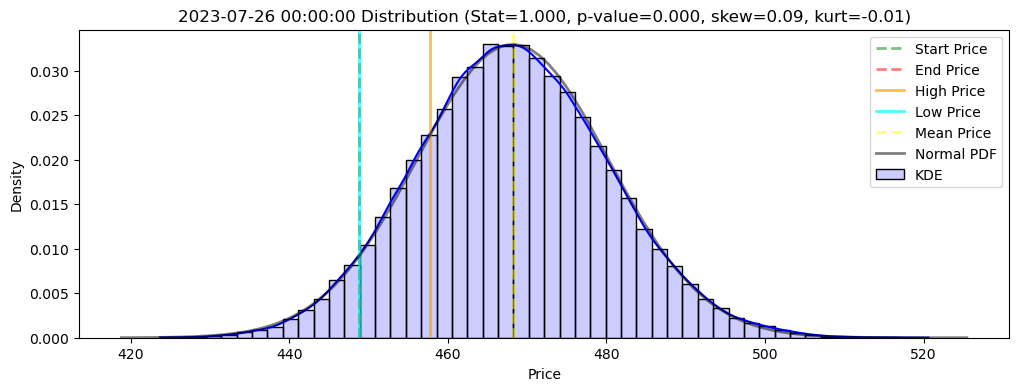

In [19]:
from scipy.stats import norm, skew, kurtosis, shapiro
import seaborn as sns

def monte_carlo(X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N , df = None, historic_df=None, model = None, scaler=None, features = FEATURES, num_simulations=100000):
    final_prices = np.zeros(num_simulations)
    final_variances = np.zeros(num_simulations)
    jump_probas = None
    jummp_mean = None
    jump_std = None

    if df is not None and model is not None and scaler is not None and historic_df is not None:
        scaled_features = scaler.transform(df[features].head(1))
        jump_probas = best_model.predict_proba(scaled_features)[0]
        jummp_mean, jump_std = calculate_fomcstats(historic_df, pd.to_datetime(df['FOMOC Meeting Date'].iloc[-1]))
        print(jump_probas) # 0: No change or less, 1: increase

    for i in range(num_simulations):
        if jump_probas is not None:
            X, variance = heston_model(X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N, pos_jump_proba=jump_probas[0], neg_jump_proba=jump_probas[1], jump_mean=jummp_mean, jump_std=jump_std)
        else:
            X, variance = heston_model(X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N )
        final_prices[i] = X[-1]
        final_variances[i] = variance[-1]

    results = pd.DataFrame({
        'final_prices': final_prices,
        'final_variances': final_variances
    })

    return results.describe(), results

def plot_results(results, start_price=None, end_price=None, fomc_date=None, high=None, low=None):
    skew_credit = skew(results['final_prices'])
    kurtosis_credit = kurtosis(results['final_prices'])
    stat, p_value = shapiro(results['final_prices'])
    normality_test_result = f'Stat={stat:.3f}, p-value={p_value:.3f}, skew={skew_credit:.2f}, kurt={kurtosis_credit:.2f}'

    plt.figure(figsize=(12, 4))
    sns.histplot(results['final_prices'], bins=50, kde=True, color='blue', edgecolor='black', alpha=0.2, stat='density', label='KDE')

    if start_price is not None:
        plt.axvline(start_price, color='green', linestyle='dashed', linewidth=2, label='Start Price', alpha=0.5)
    if end_price is not None:
        plt.axvline(end_price, color='red', linestyle='dashed', linewidth=2, label='End Price', alpha=0.5)
    if high is not None:
        plt.axvline(high, color='orange', linewidth=2, label='High Price', alpha=0.7)
    if low is not None:
        plt.axvline(low, color='cyan', linewidth=2, label='Low Price', alpha=0.7)

    plt.axvline(results['final_prices'].mean(), color='yellow', linestyle='dashed', linewidth=2, label='Mean Price', alpha=0.5)

    n_mu, n_std = norm.fit(results['final_prices'])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, n_mu, n_std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal PDF', alpha=0.5)


    plt.title(f'{fomc_date} Distribution ({normality_test_result})')
    plt.xlabel('Price')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

train_fomc = all_fomc_data_df.iloc[1:2]
test_fomc = all_fomc_data_df.iloc[2:3]

X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N= get_params(market_df, test_fomc)
summary_statistics, results = monte_carlo(X0, variance0, mu, kappa, gamma, sigma_variance, rho, T, N, df=test_fomc, historic_df=all_fomc_data_df, model=best_model, scaler=scaler)

plot_results(results,
             start_price=test_fomc['prices'].iloc[-1][-1],
             end_price=test_fomc['prices'].iloc[-1][-1],
             high=test_fomc['prices'].iloc[-1].max(),
             low=test_fomc['prices'].iloc[-1].min(),
             fomc_date= pd.to_datetime(test_fomc['FOMOC Meeting Date'].iloc[-1]))

First simulation for the meeting on 2023-07-26 was a failure, mainly because the GBC signalled weakly the status quo (probablilites: [0.77837802 0.22162198]).

# No Shock FOMC

The next FOMC meeting to be simulated is a recent one on the 2024-06-12.

In [20]:
train_fomc = all_fomc_data_df.iloc[-3:-2]
test_fomc = all_fomc_data_df.iloc[-2:-1]
test_fomc

,FOMOC Meeting Date,mean rets,prices,variance,theta,sigma_variance,rho,shock,CPI,Industry Production,...,CPI_Unemployment,CPI_Industry Production,Industry Production_Quarterly_Avg,PCE_Quarterly_Avg,Retail Sales_Quarterly_Avg,Unemployment_Quarterly_Avg,Wage Increase_Quarterly_Avg,Home Sales_Quarterly_Avg,Retail Trade_Quarterly_Avg,Real GDP_Quarterly_Avg
11,2024-06-12,0.002078,"[534.6699829101562, 534.6599731445312, 534.010...",0.00001,0.00001,0.00001,0.608059,0,314.175,103.994,...,1288.1175,32672.31495,103.251667,123.166,224750.333333,4.0,368.0,656.0,609424.666667,26726.739


[0.99433189 0.00566811]


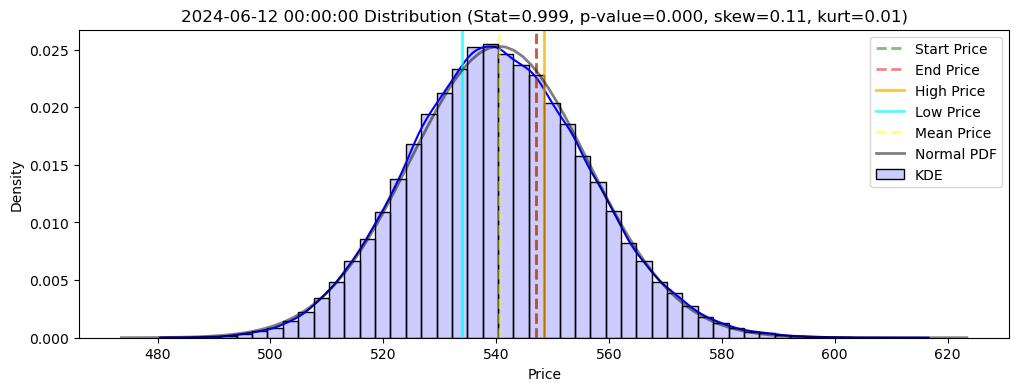

In [21]:
X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N= get_params(market_df, test_fomc)
summary_statistics, results = monte_carlo(X0, variance0, mu, kappa, gamma, sigma_variance, rho, T, N, df=test_fomc, historic_df=all_fomc_data_df, model=best_model, scaler=scaler)
plot_results(results,
             start_price=test_fomc['prices'].iloc[-1][-1],
             end_price=test_fomc['prices'].iloc[-1][-1],
             high=test_fomc['prices'].iloc[-1].max(),
             low=test_fomc['prices'].iloc[-1].min(),
             fomc_date= pd.to_datetime(test_fomc['FOMOC Meeting Date'].iloc[-1]))

This simulation was perfect, with all price ranges being central to the historic.

# FOMC 31st July 2024 Predictions

[0.98792802 0.01207198]


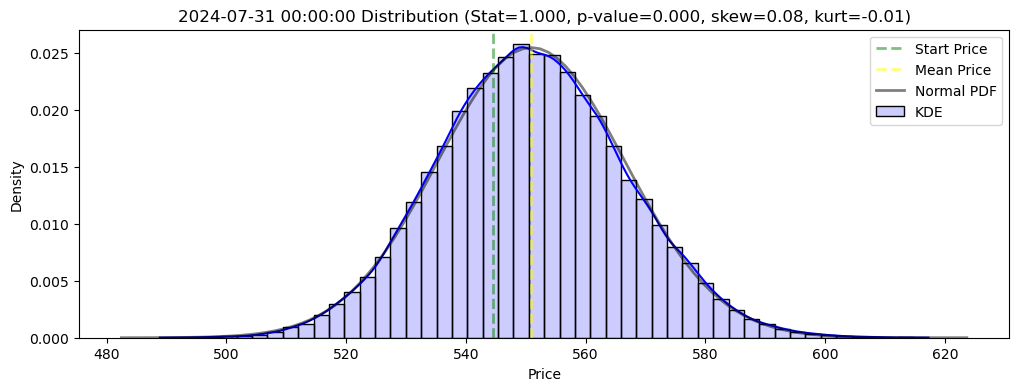

In [22]:
next_fomc = all_fomc_data_df.iloc[-1:]


X0, v0, mu, kappa, gamma, sigma_variance, rho, T, N= get_params(market_df, test_fomc)
X0 = 544.44 # SPY as 29th July 20024
N = 11

summary_statistics, results = monte_carlo(X0, variance0, mu, kappa, gamma, sigma_variance, rho, T, N, df=next_fomc, historic_df=all_fomc_data_df, model=best_model, scaler=scaler)
plot_results(results,
             start_price=X0,
             fomc_date= pd.to_datetime(next_fomc['FOMOC Meeting Date'].iloc[-1]))

In [23]:
summary_statistics

,final_prices,final_variances
count,100000.000000,100000.000000
mean,550.917386,0.161967
std,15.670390,0.000014
min,488.869086,0.161906
25%,540.211066,0.161957
50%,550.658388,0.161967
75%,561.377112,0.161977
max,617.247889,0.162029


This is the distribution for this FOMC on the 31st July 2024. The GBC predictions lean strongly to maintaining the status quo, with probabilities: [0.98792802 0.01207198] and the distribution has a slightly stronger positive skew, meaning the market should trend green on average around these 2 weeks, with SPY clustering around $550.92, and might range from $540.21 (25%) to $561.38 (75%).

# Conclusion

In this article we used a Heston stochastic process and a gradient boosting classifier to create distributions for what the next FOMC impact on the market, using the SPY ETF as a proxy.

We attempt to guess what will happen for the next meeting, on the 31st July 2024. Future readers are welcome to comment if we where close or far!

# References

- https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions
- https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm
- https://tradingeconomics.com/united-states/gdp-growth-annual
- https://www.usinflationcalculator.com/inflation/historical-inflation-rates/ 
- https://www.investopedia.com/terms/c/consumerpriceindex.asp
- https://www.investing.com/economic-calendar/retail-sales-256
- https://fred.stlouisfed.org/series/MRTSSM44000USS
- https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- https://bayesian-optimization.github.io/BayesianOptimization/code_docs.html
- https://www.probabilitycourse.com/chapter11/11_0_0_intro.php
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.poisson.html

## Github

Article and code available on [Github](https://github.com/adamd1985/quant_research/blob/main/bond_valuations.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/bond-valuations)

Google Collab available [here](https://colab.research.google.com/github/adamd1985/quant_research/blob/main/bond_valuations.ipynb)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.